# Exercise 12

## Integrantes

* Diana Díaz - Cod. 201331684
* Carlos Silva - Cod. 201920463 
* Javier Lesmes - Cod. 200820243

## Analyze how travelers expressed their feelings on Twitter

A sentiment analysis job about the problems of each major U.S. airline. 
Twitter data was scraped from February of 2015 and contributors were 
asked to first classify positive, negative, and neutral tweets, followed
by categorizing negative reasons (such as "late flight" or "rude service").

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

# read the data and set the datetime as the index
tweets = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/Tweets.zip', index_col=0)

tweets.head(10)

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)


In [2]:
tweets.shape

(14640, 14)

### Proportion of tweets with each sentiment

La variable airline_sentiment tiene tres niveles: negativo, neutro y positivo

In [3]:
tweets['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

### Proportion of tweets per airline
La data contiene información de 6 aerolíneas, *United* es las más tuiteada con el 26.1% y la menos Virgin America con el 3.4% 
También se observa en el último grafico de barras (Sentiment by airline) que la categoría de sentimientos negativos es la más prevalente dentro de cada aerolínea. 

In [4]:
tweets['airline'].value_counts()/14640*100

United            26.106557
US Airways        19.897541
American          18.845628
Southwest         16.530055
Delta             15.177596
Virgin America     3.442623
Name: airline, dtype: float64

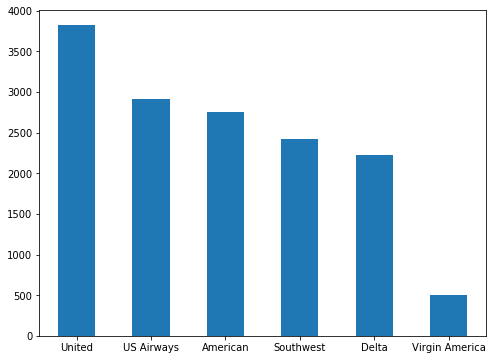

In [5]:
pd.Series(tweets["airline"]).value_counts().plot(kind = "bar",figsize=(8,6),rot = 0);

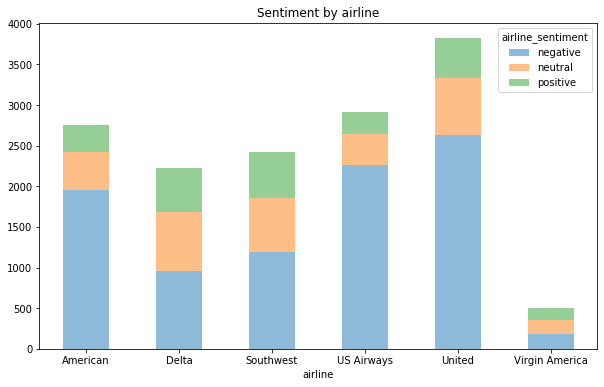

In [6]:
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiment by airline");

# Exercise 12.1 

Predict the sentiment using CountVectorizer

use Random Forest classifier

#### Valores perdidos

Las variables airline_sentiment y text no tienen registros perdidos.


In [7]:
tweets['text'].isnull().sum()

0

#### Vector (y) y tabla (X) 

* El número de tweets es 14.640 y, por tanto, X como y tienen ese número de registros
* X correspond a la varible texto. 
* La variable y corresponde a airline_sentiment con las categorías renombradas como -1, 0, 1

In [8]:
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})

In [9]:
X.iloc[0:4] # los primeros tweets

tweet_id
570306133677760513                  @VirginAmerica What @dhepburn said.
570301130888122368    @VirginAmerica plus you've added commercials t...
570301083672813571    @VirginAmerica I didn't today... Must mean I n...
570301031407624196    @VirginAmerica it's really aggressive to blast...
Name: text, dtype: object

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier as RFC
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.tree import DecisionTreeClassifier

### A. CountVectorizer

Se aplica CountVectorizer a la tabla X y posteriormente Todense, lo cual nos permite crear la tabla temp, que es un arreglo de 14.640 filas (tweets) x 15.051 columnas (palabras). Este arreglo contiene el número de veces que una palabras aparece por tweet, así que puede contener valores como 0, 1, 2, ...

In [11]:
vect = CountVectorizer() # por default pasa todas las pabablas a minuscula (lowercase)
X_dtm = vect.fit_transform(X)
temp=X_dtm.todense()
temp

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [12]:
temp.shape

(14640, 15051)

In [13]:
print(vect.get_feature_names()[10000:10020]) # imprime los tokens de las columnas 10.000 a 10.200: oversleeping, oversold, ...

['oversleeping', 'oversold', 'overtime', 'overweight', 'overwhelmed', 'overwhelming', 'overzealous', 'oveur', 'ow', 'owe', 'owed', 'owen', 'owes', 'owmaxoyehz', 'own', 'owner', 'ownership', 'owning', 'ox4w6ktsgi', 'oxgen']


In [14]:
data = pd.DataFrame(temp, columns=vect.get_feature_names())
data.head(2) # se puede ver en la tabla que el nombre de las columnas corresponde a los tokens

,00,000,000114,000419,000ft,000lbs,0011,0016,00a,00am,...,zrh_airport,zsdgzydnde,zsuztnaijq,ztrdwv0n4l,zukes,zurich,zv2pt6trk9,zv6cfpohl5,zvfmxnuelj,zzps5ywve2
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
data.iloc[0 , 1:15051].sum() # el primer tweet tiene 4 tokens

4

#### Gráfico de los primeros 50 tokens
Como se observa en el siguiente gráfico, los tokens más frecuentes son: to, the, you, united, for, flight, on, and, my, usairlines, americanair, entre otros.

C:\Users\Javier_Lesmes\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


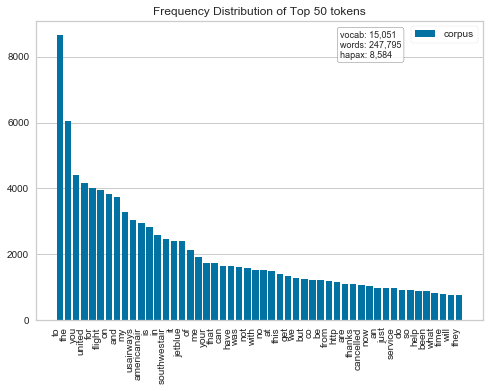

In [16]:
from yellowbrick.text import FreqDistVisualizer;
features   = vect.get_feature_names()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(X_dtm)
visualizer.show();

### B. Predecir los sentimientos hacia las aerolineas (airline_sentiment) usando Random classifier

Ejecutamos un random classifier y definimos la función tokenize_test que acepta un vectorizer y calcula el accuracy. 
Se mantienen los mismo parámetros para el clasificador en todos los casos, buscando comparabilidad entre las transformación hechas al corpus.

In [17]:
np.random.seed(123)
def tokenize_test(vect):
    X_dtm = vect.fit_transform(X)
    print('Features: ', X_dtm.shape[1])
    nb = RFC(n_estimators=10, max_depth=50)
    print(pd.Series(cross_val_score(nb, X_dtm, y, cv=5, scoring='accuracy')).mean())

In [18]:
np.random.seed(123)
vect1 = CountVectorizer()
tokenize_test(vect1)

Features:  15051
0.6844262295081966


**Desempeño** : Utilizando la tranformación vectorize se obtiene un acurracy promedio de 0.6844

# Exercise 12.2 

Remove stopwords, then predict the sentiment using CountVectorizer.

use Random Forest classifier

### A. Remove stopwords

Removemos las **English stop words** y para ello también agregamos a nuestro diccionario otras stop_words que considermos no aportan en el ánalisis, las cuales almacenamos en la lista *my_additional_stop_words*.

Posteriormente, graficamos la lista de palabras resultantes de aplicar stop_words; obteniendo que ahora las palabras más frecuentes  han cambiando y son: united, flight, usairways, americanair, southwestair, entre otras. 

Con este procedimiento, se reducen las palabras, pasando de 15.051 a 14.763.

In [19]:
from sklearn.feature_extraction import text 
my_additional_stop_words = ["ox4w6ktsgi", "acnewsguy", "alicia", "antonio", "bebetter", "asus", "owmaxoyehz"]
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

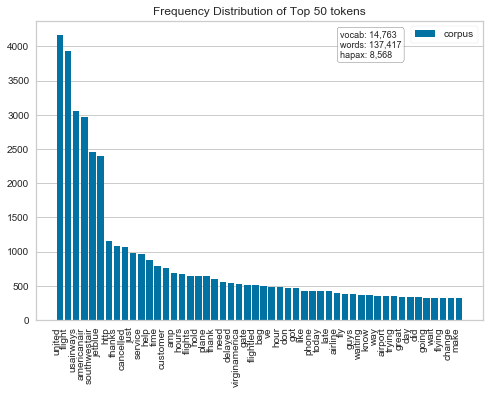

In [20]:
vect2 = CountVectorizer(stop_words=stop_words)
X_dtm2 = vect2.fit_transform(X)
features   = vect2.get_feature_names()
visualizer = FreqDistVisualizer(features=features, orient='v',colors=["yellow"])
visualizer.fit(X_dtm2)
visualizer.show();


### B. Predicción 

In [21]:
np.random.seed(123)
tokenize_test(vect2)

Features:  14763
0.648428961748634


**Desempeño sin stopwords**: Cuando se estima de nuevo el modelo de clasificación sin tener en cuenta las stopwords se obtiene un accuracy promedio de 0.6484, el cual es levemente inferior al modelo anterior (con stop words).

In [22]:
np.random.seed(123)
vect2_2 = CountVectorizer(stop_words='english', max_features=1000)
tokenize_test(vect2_2)

Features:  1000
0.6658469945355192


**Desempeño sin stop words y con max_features (seleccionando las 1000 palabras más frecuentes)**: utilizando las palabras más frecuentes se obtiene una mejora respecto a los resultados obtenidos sin stopwords anteriormente (accurcy promedio de 0.6658).

In [23]:
print(vect2_2.get_feature_names()[0:100]) # listado de las primeras 100 palabras más frecuentes

['000', '10', '100', '11', '12', '14', '15', '16', '17', '18', '19', '1hr', '1k', '1st', '20', '200', '2015', '21', '22', '23', '24', '25', '2hrs', '2nd', '30', '35', '3rd', '40', '45', '50', '60', '728', '75', '800', '90', 'aa', 'able', 'absolute', 'absolutely', 'acceptable', 'access', 'account', 'actual', 'actually', 'add', 'added', 'address', 'advisory', 'afternoon', 'agent', 'agents', 'ago', 'air', 'aircraft', 'airline', 'airlines', 'airplane', 'airport', 'airports', 'airways', 'allow', 'allowed', 'amazing', 'america', 'american', 'americanair', 'americanairlines', 'amp', 'angry', 'answer', 'answered', 'answering', 'answers', 'anymore', 'apology', 'app', 'apparently', 'appease', 'appreciate', 'appreciated', 'area', 'aren', 'arrival', 'arrive', 'arrived', 'arriving', 'asap', 'ask', 'asked', 'asking', 'assist', 'assistance', 'atl', 'atlanta', 'attendant', 'attendants', 'attitude', 'austin', 'auto', 'automated']


# Exercise 12.3

Increase n_grams size (with and without stopwords),  then predict the sentiment using CountVectorizer

use Random Forest classifier

### A. n_grams with stopwords

In [24]:
vect3_1 = CountVectorizer(ngram_range=(1, 3))
np.random.seed(123)
tokenize_test(vect3_1)

Features:  293223
0.6418715846994536


**Desempeño con n_grams y stopwords**: Cuando se incluyen n_gramas (1,3) en la predicción, se obtiene un accuracy promedio de 0.6418. Este accuracy es inferior a los obtenidos anteriormente.

En este caso las columna de la tabla X aumentaron a 293.223

In [25]:
print(vect3_1.get_feature_names()[10000:10020]) # lista de algunos n_grams

['about her bag', 'about hiring', 'about hiring more', 'about hiring some', 'about hotel', 'about hotel like', 'about hour', 'about hour over', 'about hours', 'about hours ago', 'about hours because', 'about how', 'about how awesome', 'about how technology', 'about how wifi', 'about how you', 'about how your', 'about hrs', 'about hrs ago', 'about http']


### B. n_grams without stopwords

In [26]:
np.random.seed(123)
vect3_2 = CountVectorizer(stop_words=stop_words, ngram_range=(1, 3))
tokenize_test(vect3_2)

Features:  200983
0.6331967213114754


**Desempeño con n_grams pero sin stopwords**: Cuando se eliminan las stopwords de la estimación con n_gramas (1,3)  se obtiene un accuracy de 0.6332, que es ligeramente inferior en relación con el modelo anterior. 

En este caso las columnas de la tabla de entrada son 200.983.

In [27]:
print(vect3_2.get_feature_names()[10000:10020]) # lista de algunos n_grams removiendo stopwords

['abysmal customer', 'abysmal customer service', 'abysmal hour', 'abysmal hour runway', 'abysmal ve', 'abysmal ve phone', 'ac', 'ac reservation', 'ac reservation whats', 'ac sit', 'ac sit 21l', 'ac ua1510', 'ac ua1510 took', 'ac went', 'ac went 20', 'ac6zwmuoon', 'acarl4', 'acarl4 hotmail', 'acarl4 hotmail com', 'acc']


# Exercise 12.4

Predict the sentiment using TfidfVectorizer.

use Random Forest classifier

### A.TD-IDF with stopwords

In [28]:
vect4_1 = TfidfVectorizer() 
np.random.seed(123)
tokenize_test(vect4_1)

Features:  15051
0.6857240437158469


**Desempeño del modelo usando TfidfVectorizer con stopwords**: Cuando se estima el modelo utilizando Term Frequency-Inverse Document Frequency (TF-IDF) se obtiene un accuracy promedio de 0.6857, el mejor resultado obtenido hasta ahora.

En este caso, la tabla tranformada tiene las mismas 15.051 columnas iniciales (12.2) porque básicamente lo que se hizo fue calcular:

(Número de veces que la palabra está el el tuit)/(cantidad de tuits en que se encuentra la palabra)

In [29]:
print(vect4_1.get_feature_names()[1:50]) # muestra los primeros tokens

['000', '000114', '000419', '000ft', '000lbs', '0011', '0016', '00a', '00am', '00p', '00pm', '01', '0162389030167', '0162424965446', '0162431184663', '0167560070877', '0185', '01ldxn3qqq', '01pm', '02', '0200', '03', '0316', '0372389047497', '04', '0400', '04sdytt7zd', '05', '0510', '0530', '05am', '05pm', '06', '0600', '0638', '0671', '07', '0736', '0769', '07p', '07xhcacjax', '08', '0985', '0_0', '0bjnz4eix5', '0cevy3p42b', '0ewj7oklji', '0hmmqczkcf', '0hxlnvzknp']


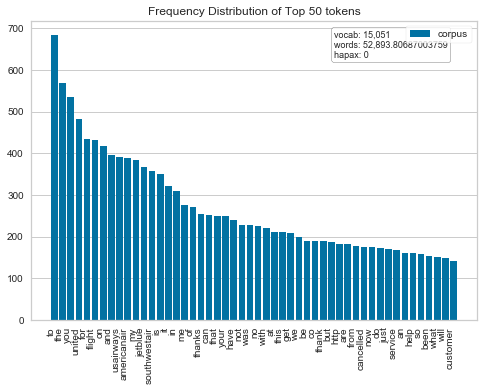

In [30]:
vect4_1 = TfidfVectorizer()
X_dtm4 = vect4_1.fit_transform(X)
features4   = vect4_1.get_feature_names()
visualizer = FreqDistVisualizer(features=features4, orient='v',colors=["yellow"])
visualizer.fit(X_dtm4)
visualizer.show();

En el gráfico anterior se muestran cuales son los tokens más frecuentes. Puntualmente, el top 5 está compuesto por: to, the, you, united, for.

### B.TD-IDF without stopwords

In [31]:
vect4_2 = TfidfVectorizer(stop_words='english') 
np.random.seed(123)
tokenize_test(vect4_2)

Features:  14770
0.6564890710382514


**Desempeño del modelo usando TfidfVectorizer sin stopwords**: Cuando se estima el modelo utilizando Term Frequency-Inverse Document Frequency (TF-IDF) sin stopwords se obtiene un accuracy promedio de 0.6564, que es inferior al obtenido anteriormente y parece estar indicando que algunas de las palabras eliminadas son importante para la predicción del sentimiento del tweet.

En este caso las columnas de la tabla de entrada son 14.770.

### C.TD-IDF with n-grams and stopwords

In [32]:
vect4_3 = TfidfVectorizer(ngram_range=(1, 3)) 
np.random.seed(123)
tokenize_test(vect4_3)

Features:  293223
0.6474043715846995


**Desempeño del modelo usando TfidfVectorizer con n-gramas y stopwords**: Cuando se estima el modelo utilizando Term Frequency-Inverse Document Frequency (TF-IDF) con n-grmas (1,3) y stopwords, se obtiene un accuracy promedio de 0.6564, que es inferior al obtenido anteriormente. Este resultado es consistente con las estimaciones iniciales sin TF-IDF. Cuando se estima el modelo con n-gramas el accuracy desminuye.

En este caso las columnas de la tabla de entrada son 293.223.

### D. TD-IDF with n-grams but without stopwords

In [33]:
vect4_4 = TfidfVectorizer(ngram_range=(1, 3), stop_words='english') 
np.random.seed(123)
tokenize_test(vect4_4)

Features:  201010
0.6390710382513661


**Desempeño del modelo usando TfidfVectorizer con n-gramas sin stopwords**: Cuando se estima el modelo utilizando Term Frequency-Inverse Document Frequency (TF-IDF) con n-grmas (1,3) pero sin stopwords, se obtiene un accuracy promedio de 0.6391, que es el menor obtenido en el punto 12.4.

En este caso las columnas de la tabla de entrada son 201.010.

### F. TD-IDF ajusted

Finalmente, se prueba un modelo que incluye algunos de los parámetros analizados anteiormente, junto con algunos ajustes adicionales como eliminar puntuación y trabajar con las raíces (o base) de las palabras, con el objetivo de explorar posibles mejoras de los resultados obtenidos hasta este momento. Concretamente se implementó:

1. eliminación de puntuación
2. stemming 
3. n_grams
4. Max_futures

In [34]:
X1=X 
X.head(2)

tweet_id
570306133677760513                  @VirginAmerica What @dhepburn said.
570301130888122368    @VirginAmerica plus you've added commercials t...
Name: text, dtype: object

In [35]:
def remove_punctuation(text):
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [36]:
X1 = X1.apply(remove_punctuation)
X1.head() # se han eliminado expresiones como el @ y '

tweet_id
570306133677760513                     VirginAmerica What dhepburn said
570301130888122368    VirginAmerica plus youve added commercials to ...
570301083672813571    VirginAmerica I didnt today Must mean I need t...
570301031407624196    VirginAmerica its really aggressive to blast o...
570300817074462722    VirginAmerica and its a really big bad thing a...
Name: text, dtype: object

In [37]:
stemmer = SnowballStemmer('english')
def stemming(text):    
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 

In [38]:
X1 = X1.apply(stemming) # se dejan las raices de las palabras
X1.head(2)

tweet_id
570306133677760513                     virginamerica what dhepburn said
570301130888122368    virginamerica plus youv ad commerci to the exp...
Name: text, dtype: object

In [39]:
#max_df lo utilizamos para ignorar los términos que aprecen en más del 90% de los textos
vectF = TfidfVectorizer(max_features=10000,ngram_range=(1, 3), max_df=0.9)
X_dtmF = vectF.fit_transform(X1)
tempF = X_dtmF.todense()
tempF

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [40]:
tempF.shape

(14640, 10000)

In [41]:
print(vectF.get_feature_names()[1:50]) 

['10 day', '10 hour', '10 hrs', '10 min', '10 minut', '10 of', '100', '100 peopl', '1000', '10000', '1024', '1030', '10pm', '11', '1130', '12', '12 hour', '12 hrs', '1200', '1230', '13', '130', '136', '14', '140', '140 charact', '15', '15 hour', '15 hrs', '15 min', '15 minut', '150', '15th', '16', '17', '18', '180', '1800', '19', '1hr', '1k', '1pm', '1st', '1st class', '1st class seat', '1st flight', '1st time', '20', '20 min']


In [42]:
dataF = pd.DataFrame(tempF, columns=vectF.get_feature_names())# muestra la tabla después del tfidf
dataF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Columns: 10000 entries, 10 to zone
dtypes: float64(10000)
memory usage: 1.1 GB


In [43]:
mdl = RFC(n_estimators=10, max_depth=50)
print(np.mean(cross_val_score(mdl, dataF, y, cv=5, scoring='accuracy')))

0.6991803278688524


**Desempeño del modelo ajustado**: Cuando se realizan los ajustes indicados, se obtiene un accuracy promedio de 0.6991. Este accuracy es el más alto de todos las estimaciones realizadas a lo largo del taller.

#### Conclusión:
La estadística de desempeño depende del tratamiento realizado y de la forma cómo se aborden los textos de los tweets. Para este caso trabajar con Term Frequency-Inverse Document Frequency (TF-IDF) mejoró los resultados en varios de los ejercicios realizados.
